# Regression Model Training and Evaluation
This notebook contains training and evaluation of machine learning models for regression.

## Models to evaluate:
1. **Multivariate Linear Regression** (LinearRegression)
2. **Support Vector Regression (SVR)**
3. **XGBoost Regressor**

## Objectives:
- Train models with different hyperparameters
- Evaluate performance with regression metrics
- Analyze feature importance
- Compare models and select the best one

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
#import xgboost as xgb
from scipy import stats
import warnings

## 1. Data Loading and Preparation

In [2]:
dataset_path = '../cloud-data/its-cmo-darwin-magellan-workspaces-folders/WS_PMCB/BisCiT_Repository/results/current_version/v2.0c/aa/dtl-surfaceome-secretome-equal_0.1/results-with-evidence-full.txt'

In [3]:
file_path = dataset_path

df = pd.read_csv(file_path, sep='\t')
print(f"Dataset loaded successfully: {df.shape[0]} rows and {df.shape[1]} columns")

Dataset loaded successfully: 11943461 rows and 19 columns


In [4]:
df.head(2)

,Gene 1,Gene 2,AA Score,Genetics,Knowledge Graph Connectivity,Single Cell DE,Single Cell Expression,Single Cell Specificity,Ligand Receptor Significance,"SC KO, positive",Credentialing,Credentialing bulk RNA,"SC KO, Negative","DTL, Th1-17","DTL, Th2",Immune Competition,"Single Cell Co-dysregulation, positive","Single Cell Co-dysregulation, negative","Single Cell Co-dysregulation, mixed"
0,CTLA4,IL2RA,3.750244,0.850673,0.932113,0.0,0.266357,0.230324,0.363851,0.157781,0.952958,0.0,-0.003812,NaN,NaN,0.0,0.0,0.0,0.0
1,IL2RA,TNFRSF1A,3.516827,0.723262,0.741249,0.0,0.334782,0.177688,0.462156,0.480434,0.669561,0.0,-0.072305,NaN,NaN,0.0,0.0,0.0,0.0


In [5]:
df.columns

Index(['Gene 1', 'Gene 2', 'AA Score', 'Genetics',
       'Knowledge Graph Connectivity', 'Single Cell DE',
       'Single Cell Expression', 'Single Cell Specificity',
       'Ligand Receptor Significance', 'SC KO, positive', 'Credentialing',
       'Credentialing bulk RNA', 'SC KO, Negative', 'DTL, Th1-17', 'DTL, Th2',
       'Immune Competition', 'Single Cell Co-dysregulation, positive',
       'Single Cell Co-dysregulation, negative',
       'Single Cell Co-dysregulation, mixed'],
      dtype='object')

## Selection of features and target columns

In [6]:
features_columns = ['Genetics',
       'Knowledge Graph Connectivity', 'Single Cell DE',
       'Single Cell Expression', 'Single Cell Specificity',
       'Ligand Receptor Significance', 'SC KO, positive', 'Credentialing',
       'Credentialing bulk RNA', 'SC KO, Negative']

In [7]:
# Data preparation
# Separate features and target variable
feature_cols = [col for col in features_columns]
X = df[feature_cols]
y = df['AA Score']

print(f"Selected features: {feature_cols}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Check for missing values
missing_X = X.isnull().sum().sum()
missing_y = y.isnull().sum()
print(f"\nMissing values in X: {missing_X}")
print(f"Missing values in y: {missing_y}")

# Remove rows with missing values if they exist
if missing_X > 0 or missing_y > 0:
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    print(f"After cleaning data: X={X.shape}, y={y.shape}")

Selected features: ['Genetics', 'Knowledge Graph Connectivity', 'Single Cell DE', 'Single Cell Expression', 'Single Cell Specificity', 'Ligand Receptor Significance', 'SC KO, positive', 'Credentialing', 'Credentialing bulk RNA', 'SC KO, Negative']
X shape: (11943461, 10)
y shape: (11943461,)

Missing values in X: 0
Missing values in y: 0


In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train/test ratio: {X_train.shape[0]/X_test.shape[0]:.1f}")

# Target variable statistics
print(f"\nTarget variable statistics:")
print(f"Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

Training set: 9554768 samples
Test set: 2388693 samples
Train/test ratio: 4.0

Target variable statistics:
Train - Mean: 0.22, Std: 0.24
Test  - Mean: 0.22, Std: 0.24


## 2. Feature Scaling

In [9]:
# Prepare different scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
    'NoScaler': None
}

# Function to apply scaling
def apply_scaling(scaler, X_train, X_test):
    if scaler is None:
        return X_train, X_test
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

print("Scalers prepared:")
for name in scalers.keys():
    print(f"  • {name}")

Scalers prepared:
  • StandardScaler
  • RobustScaler
  • NoScaler


## 3. Evaluation Metrics Definition

In [10]:
def calculate_metrics(y_true, y_pred):
    """Calculate multiple regression metrics"""
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100,
        'Adjusted_R²': 1 - (1 - r2_score(y_true, y_pred)) * (len(y_true) - 1) / (len(y_true) - X_train.shape[1] - 1)
    }
    return metrics

def print_metrics(metrics, title="Metrics"):
    """Print metrics in organized format"""
    print(f"\n=== {title} ===")
    for metric, value in metrics.items():
        if metric in ['R²', 'Adjusted_R²']:
            print(f"{metric}: {value:.4f}")
        elif metric == 'MAPE':
            print(f"{metric}: {value:.2f}%")
        else:
            print(f"{metric}: {value:.4f}")

print("Metrics functions defined")

Metrics functions defined


## 4. Model 1: Linear Regression with Regularization

In [11]:
print("🔍 TRAINING LINEAR REGRESSION MODELS")

# Linear regression models to test
linear_models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(max_iter=2000),
    'ElasticNet': ElasticNet(max_iter=2000)
}

# Hyperparameters for search
linear_params = {
    'Ridge': {'alpha': [0.1, 1, 10, 100, 1000]},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    'ElasticNet': {
        'alpha': [0.001, 0.01, 0.1, 1],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
}

# Linear model results
linear_results = {}

# Use StandardScaler for linear models
scaler = StandardScaler()
#X_train_scaled, X_test_scaled = apply_scaling(scaler, X_train, X_test)
X_train_scaled, X_test_scaled = X_train, X_test

for model_name, model in linear_models.items():
    print(f"\n🔧 Training {model_name}...")
    
    if model_name in linear_params:
        # Hyperparameter search with cross-validation
        grid_search = GridSearchCV(
            model, linear_params[model_name], 
            cv=5, scoring='neg_mean_squared_error', 
            n_jobs=-1
        )
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        print(f"  Best hyperparameters: {grid_search.best_params_}")
    else:
        # Model without hyperparameters
        best_model = model
        best_model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = best_model.predict(X_train_scaled)
    y_test_pred = best_model.predict(X_test_scaled)
    
    # Metrics
    train_metrics = calculate_metrics(y_train, y_train_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    cv_rmse_std = np.sqrt(cv_scores.std())
    
    linear_results[model_name] = {
        'model': best_model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'cv_rmse': cv_rmse,
        'cv_rmse_std': cv_rmse_std,
        'predictions': {'train': y_train_pred, 'test': y_test_pred}
    }
    
    print_metrics(train_metrics, "Training")
    print_metrics(test_metrics, "Test")
    print(f"CV RMSE: {cv_rmse:.4f} (±{cv_rmse_std:.4f})")

print("\n✅ Linear models trained successfully")

🔍 TRAINING LINEAR REGRESSION MODELS

🔧 Training LinearRegression...

=== Training ===
RMSE: 0.0000
MAE: 0.0000
R²: 1.0000
MAPE: 0.00%
Adjusted_R²: 1.0000

=== Test ===
RMSE: 0.0000
MAE: 0.0000
R²: 1.0000
MAPE: 0.00%
Adjusted_R²: 1.0000
CV RMSE: 0.0000 (±0.0000)

🔧 Training Ridge...
  Best hyperparameters: {'alpha': 0.1}

=== Training ===
RMSE: 0.0000
MAE: 0.0000
R²: 1.0000
MAPE: 289.79%
Adjusted_R²: 1.0000

=== Test ===
RMSE: 0.0000
MAE: 0.0000
R²: 1.0000
MAPE: 285.23%
Adjusted_R²: 1.0000
CV RMSE: 0.0000 (±0.0000)

🔧 Training Lasso...
  Best hyperparameters: {'alpha': 0.001}

=== Training ===
RMSE: 0.0564
MAE: 0.0386
R²: 0.9435
MAPE: 24105640.33%
Adjusted_R²: 0.9435

=== Test ===
RMSE: 0.0565
MAE: 0.0386
R²: 0.9434
MAPE: 23726757.01%
Adjusted_R²: 0.9434
CV RMSE: 0.0564 (±0.0037)

🔧 Training ElasticNet...
  Best hyperparameters: {'alpha': 0.001, 'l1_ratio': 0.1}

=== Training ===
RMSE: 0.0391
MAE: 0.0274
R²: 0.9728
MAPE: 18765079.42%
Adjusted_R²: 0.9728

=== Test ===
RMSE: 0.0392
MAE: 0

## 5. Model 2: Support Vector Regression (SVR)

In [12]:
print("🔍 TRAINING SUPPORT VECTOR REGRESSION")

# Hyperparameters for SVR
svr_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1]
}

# Different kernels to test
svr_kernels = ['linear', 'rbf', 'poly']
svr_results = {}

# Use RobustScaler for SVR (more robust to outliers)
robust_scaler = RobustScaler()
#X_train_robust, X_test_robust = apply_scaling(robust_scaler, X_train, X_test)

X_train_robust, X_test_robust = X_train, X_test

for kernel in svr_kernels:
    print(f"\n🔧 Training SVR with {kernel} kernel...")
    
    # Create SVR model
    svr_model = SVR(kernel=kernel)
    
    # Adjust parameters according to kernel
    current_params = svr_params.copy()
    if kernel == 'linear':
        current_params.pop('gamma')  # Gamma not relevant for linear kernel
    elif kernel == 'poly':
        current_params['degree'] = [2, 3, 4]  # Add degree for polynomial
    
    # Hyperparameter search
    grid_search = GridSearchCV(
        svr_model, current_params, 
        cv=5, scoring='neg_mean_squared_error', 
        n_jobs=1, verbose=0
    )
    
    grid_search.fit(X_train_robust, y_train)
    best_svr = grid_search.best_estimator_
    
    print(f"  Best hyperparameters: {grid_search.best_params_}")
    
    # Predictions
    y_train_pred = best_svr.predict(X_train_robust)
    y_test_pred = best_svr.predict(X_test_robust)
    
    # Metrics
    train_metrics = calculate_metrics(y_train, y_train_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(best_svr, X_train_robust, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    cv_rmse_std = np.sqrt(cv_scores.std())
    
    svr_results[f'SVR_{kernel}'] = {
        'model': best_svr,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'cv_rmse': cv_rmse,
        'cv_rmse_std': cv_rmse_std,
        'predictions': {'train': y_train_pred, 'test': y_test_pred}
    }
    
    print_metrics(train_metrics, "Training")
    print_metrics(test_metrics, "Test")
    print(f"CV RMSE: {cv_rmse:.4f} (±{cv_rmse_std:.4f})")

print("\n✅ SVR models trained successfully")

🔍 TRAINING SUPPORT VECTOR REGRESSION

🔧 Training SVR with linear kernel...


KeyboardInterrupt: 

## 6. Model 3: XGBoost Regressor

In [ ]:
print("🔍 TRAINING XGBOOST REGRESSOR")

# Hyperparameters for XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Create XGBoost model
xgb_model = xgb.XGBRegressor(
    random_state=42,
    verbosity=0,
    eval_metric='rmse'
)

# XGBoost doesn't require scaling, use original data
print("🔧 Training XGBoost (may take several minutes)...")

# Random search to reduce computation time
from sklearn.model_selection import RandomizedSearchCV

# Use RandomizedSearchCV instead of GridSearchCV for efficiency
random_search = RandomizedSearchCV(
    xgb_model, xgb_params,
    n_iter=50,  # Number of combinations to test
    cv=5, scoring='neg_mean_squared_error',
    n_jobs=-1, random_state=42,
    verbose=0
)

random_search.fit(X_train, y_train)
best_xgb = random_search.best_estimator_

print(f"  Best hyperparameters: {random_search.best_params_}")

# Predictions
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

# Metrics
train_metrics = calculate_metrics(y_train, y_train_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

# Cross-validation
cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores.mean())
cv_rmse_std = np.sqrt(cv_scores.std())

xgb_results = {
    'model': best_xgb,
    'train_metrics': train_metrics,
    'test_metrics': test_metrics,
    'cv_rmse': cv_rmse,
    'cv_rmse_std': cv_rmse_std,
    'predictions': {'train': y_train_pred, 'test': y_test_pred}
}

print_metrics(train_metrics, "Training")
print_metrics(test_metrics, "Test")
print(f"CV RMSE: {cv_rmse:.4f} (±{cv_rmse_std:.4f})")

print("\n✅ XGBoost model trained successfully")

## 7. Model Comparison

In [12]:
# Combine all results
#all_results = {**linear_results, **svr_results, 'XGBoost': xgb_results}
all_results = {**linear_results}

# Create comparison DataFrame
comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Train_RMSE': results['train_metrics']['RMSE'],
        'Test_RMSE': results['test_metrics']['RMSE'],
        'Train_R²': results['train_metrics']['R²'],
        'Test_R²': results['test_metrics']['R²'],
        'Train_MAE': results['train_metrics']['MAE'],
        'Test_MAE': results['test_metrics']['MAE'],
        'CV_RMSE': results['cv_rmse'],
        'CV_RMSE_Std': results['cv_rmse_std'],
        'Overfitting': results['train_metrics']['RMSE'] - results['test_metrics']['RMSE']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test_R²', ascending=False)

print("=== MODEL COMPARISON ===")
display(comparison_df.round(4))

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test R²: {comparison_df.iloc[0]['Test_R²']:.4f}")
print(f"   Test RMSE: {comparison_df.iloc[0]['Test_RMSE']:.4f}")
print(f"   CV RMSE: {comparison_df.iloc[0]['CV_RMSE']:.4f} (±{comparison_df.iloc[0]['CV_RMSE_Std']:.4f})")

=== MODEL COMPARISON ===


,Model,Train_RMSE,Test_RMSE,Train_R²,Test_R²,Train_MAE,Test_MAE,CV_RMSE,CV_RMSE_Std,Overfitting
0,LinearRegression,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,-0.0000
1,Ridge,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,-0.0000
3,ElasticNet,0.0391,0.0392,0.9728,0.9728,0.0274,0.0274,0.0391,0.0024,-0.0001
2,Lasso,0.0564,0.0565,0.9435,0.9434,0.0386,0.0386,0.0564,0.0037,-0.0001



🏆 BEST MODEL: LinearRegression
   Test R²: 1.0000
   Test RMSE: 0.0000
   CV RMSE: 0.0000 (±0.0000)


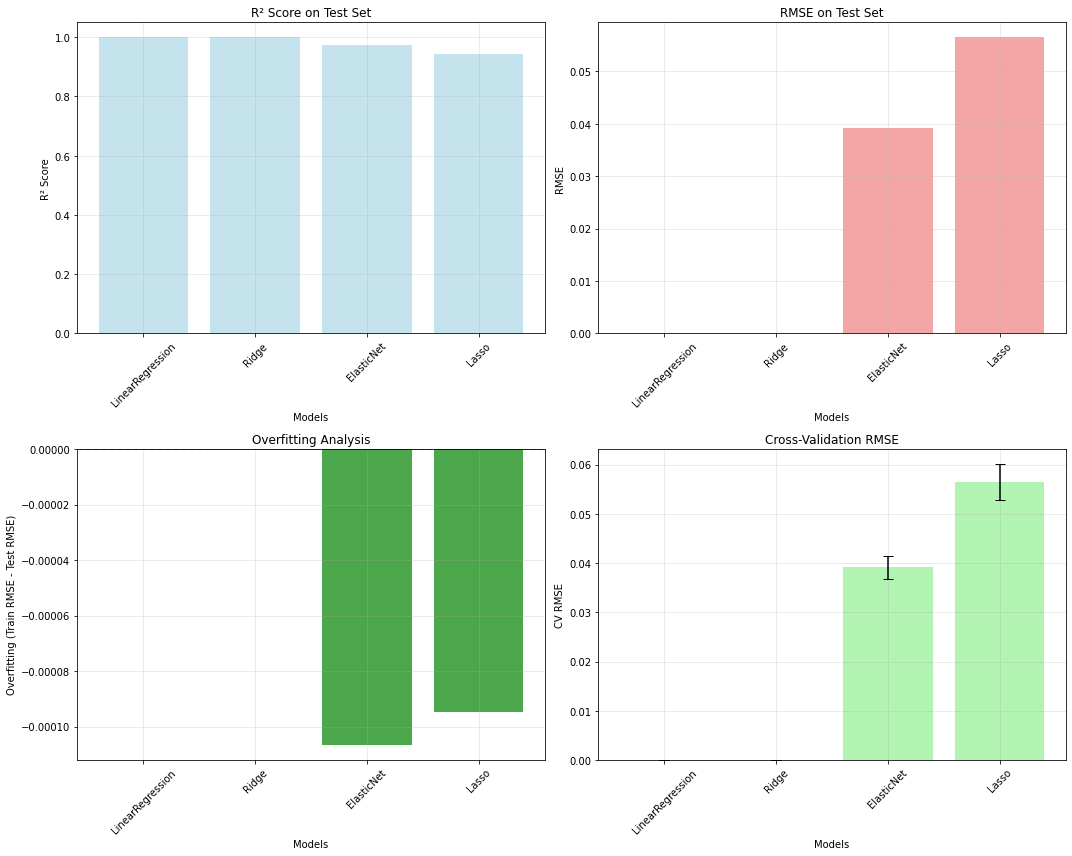

In [13]:
# Model comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# R² Score
ax1 = axes[0, 0]
x_pos = np.arange(len(comparison_df))
ax1.bar(x_pos, comparison_df['Test_R²'], alpha=0.7, color='lightblue')
ax1.set_xlabel('Models')
ax1.set_ylabel('R² Score')
ax1.set_title('R² Score on Test Set')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df['Model'], rotation=45)
ax1.grid(True, alpha=0.3)

# RMSE
ax2 = axes[0, 1]
ax2.bar(x_pos, comparison_df['Test_RMSE'], alpha=0.7, color='lightcoral')
ax2.set_xlabel('Models')
ax2.set_ylabel('RMSE')
ax2.set_title('RMSE on Test Set')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(comparison_df['Model'], rotation=45)
ax2.grid(True, alpha=0.3)

# Overfitting (Train RMSE - Test RMSE)
ax3 = axes[1, 0]
colors = ['red' if x > 0 else 'green' for x in comparison_df['Overfitting']]
ax3.bar(x_pos, comparison_df['Overfitting'], alpha=0.7, color=colors)
ax3.set_xlabel('Models')
ax3.set_ylabel('Overfitting (Train RMSE - Test RMSE)')
ax3.set_title('Overfitting Analysis')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(comparison_df['Model'], rotation=45)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Cross-Validation RMSE with error bars
ax4 = axes[1, 1]
ax4.bar(x_pos, comparison_df['CV_RMSE'], alpha=0.7, color='lightgreen',
        yerr=comparison_df['CV_RMSE_Std'], capsize=5)
ax4.set_xlabel('Models')
ax4.set_ylabel('CV RMSE')
ax4.set_title('Cross-Validation RMSE')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(comparison_df['Model'], rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

🔍 ANALYZING FEATURE IMPORTANCE


NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

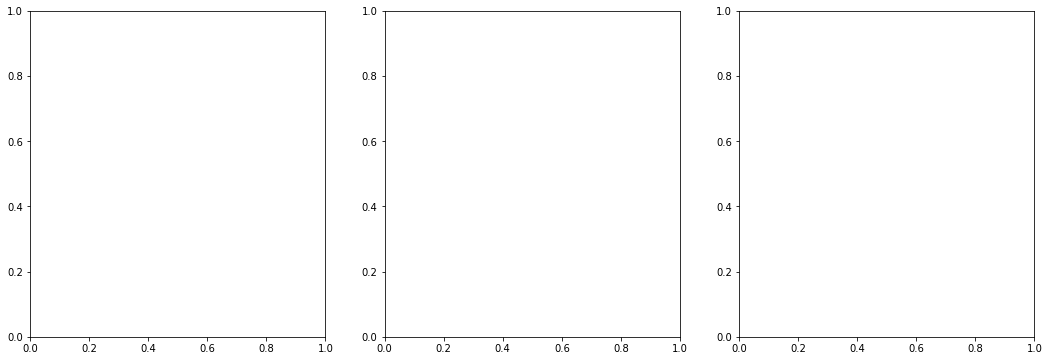

In [14]:
print("🔍 ANALYZING FEATURE IMPORTANCE")

# Function to get feature importance
def get_feature_importance(model, model_name, X_test, y_test):
    """Get feature importance according to model type"""
    
    if hasattr(model, 'feature_importances_'):
        # Models with feature_importances_ (XGBoost, RandomForest, etc.)
        importance = model.feature_importances_
        method = 'Built-in Feature Importance'
    
    elif hasattr(model, 'coef_'):
        # Linear models
        importance = np.abs(model.coef_)
        method = 'Absolute Coefficients'
    
    else:
        # Use permutation importance for other models
        perm_importance = permutation_importance(
            model, X_test, y_test, 
            n_repeats=10, random_state=42, 
            scoring='neg_mean_squared_error'
        )
        importance = perm_importance.importances_mean
        method = 'Permutation Importance'
    
    return importance, method

# Analyze importance for top 3 models
top_3_models = comparison_df.head(3)
importance_results = {}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (_, row) in enumerate(top_3_models.iterrows()):
    model_name = row['Model']
    model_obj = all_results[model_name]['model']
    
    # Prepare test data according to model
    if model_name.startswith('SVR'):
        X_test_prepared = robust_scaler.transform(X_test)
    elif model_name in ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']:
        X_test_prepared = scaler.transform(X_test)
    else:  # XGBoost
        X_test_prepared = X_test
    
    importance, method = get_feature_importance(model_obj, model_name, X_test_prepared, y_test)
    
    # Normalize importance
    importance_normalized = importance / importance.sum()
    
    # Create DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importance_normalized
    }).sort_values('Importance', ascending=True)
    
    importance_results[model_name] = importance_df
    
    # Plot
    ax = axes[i]
    colors = plt.cm.viridis(np.linspace(0, 1, len(importance_df)))
    bars = ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
    ax.set_title(f'{model_name}\n({method})')
    ax.set_xlabel('Normalized Importance')
    ax.grid(True, alpha=0.3)
    
    # Add values on bars
    for bar, importance in zip(bars, importance_df['Importance']):
        ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
                f'{importance:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print feature importance ranking
print("\n=== FEATURE IMPORTANCE RANKING ===")
for model_name, imp_df in importance_results.items():
    print(f"\n{model_name}:")
    for i, (_, row) in enumerate(imp_df.sort_values('Importance', ascending=False).iterrows(), 1):
        print(f"  {i}. {row['Feature']}: {row['Importance']:.4f}")

## 9. Residual Analysis of Best Model

In [ ]:
# Select best model for detailed analysis
best_model_results = all_results[best_model_name]
best_model = best_model_results['model']
y_train_pred = best_model_results['predictions']['train']
y_test_pred = best_model_results['predictions']['test']

print(f"🔍 RESIDUAL ANALYSIS - {best_model_name}")

# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Create residual analysis plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Predictions vs Actual Values (Train)
ax1 = axes[0, 0]
ax1.scatter(y_train, y_train_pred, alpha=0.6, s=20)
min_val = min(y_train.min(), y_train_pred.min())
max_val = max(y_train.max(), y_train_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predictions')
ax1.set_title('Train: Predictions vs Actual')
ax1.grid(True, alpha=0.3)

# 2. Predictions vs Actual Values (Test)
ax2 = axes[0, 1]
ax2.scatter(y_test, y_test_pred, alpha=0.6, s=20, color='orange')
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predictions')
ax2.set_title('Test: Predictions vs Actual')
ax2.grid(True, alpha=0.3)

# 3. Residuals vs Predictions (Test)
ax3 = axes[0, 2]
ax3.scatter(y_test_pred, test_residuals, alpha=0.6, s=20, color='green')
ax3.axhline(y=0, color='r', linestyle='--')
ax3.set_xlabel('Predictions')
ax3.set_ylabel('Residuals')
ax3.set_title('Residuals vs Predictions (Test)')
ax3.grid(True, alpha=0.3)

# 4. Histogram of Residuals (Train)
ax4 = axes[1, 0]
ax4.hist(train_residuals, bins=30, alpha=0.7, density=True, color='skyblue')
ax4.axvline(train_residuals.mean(), color='red', linestyle='--', label=f'Mean: {train_residuals.mean():.3f}')
ax4.set_xlabel('Residuals')
ax4.set_ylabel('Density')
ax4.set_title('Residual Distribution (Train)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Histogram of Residuals (Test)
ax5 = axes[1, 1]
ax5.hist(test_residuals, bins=30, alpha=0.7, density=True, color='orange')
ax5.axvline(test_residuals.mean(), color='red', linestyle='--', label=f'Mean: {test_residuals.mean():.3f}')
ax5.set_xlabel('Residuals')
ax5.set_ylabel('Density')
ax5.set_title('Residual Distribution (Test)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Q-Q Plot of Residuals (Test)
ax6 = axes[1, 2]
stats.probplot(test_residuals, dist="norm", plot=ax6)
ax6.set_title('Q-Q Plot of Residuals (Test)')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual statistics
print(f"\n=== RESIDUAL STATISTICS ===")
print(f"Train:")
print(f"  Mean: {train_residuals.mean():.6f}")
print(f"  Std: {train_residuals.std():.4f}")
print(f"  Skewness: {stats.skew(train_residuals):.4f}")
print(f"  Kurtosis: {stats.kurtosis(train_residuals):.4f}")

print(f"\nTest:")
print(f"  Mean: {test_residuals.mean():.6f}")
print(f"  Std: {test_residuals.std():.4f}")
print(f"  Skewness: {stats.skew(test_residuals):.4f}")
print(f"  Kurtosis: {stats.kurtosis(test_residuals):.4f}")

# Normality test for residuals
_, p_value = stats.shapiro(test_residuals[:1000] if len(test_residuals) > 1000 else test_residuals)
print(f"\nNormality Test (Shapiro-Wilk): p-value = {p_value:.6f}")
print(f"Residuals are normal: {'Yes' if p_value > 0.05 else 'No'}")

## 10. Learning and Validation Curves

In [ ]:
from sklearn.model_selection import learning_curve

print(f"🔍 GENERATING LEARNING CURVES FOR {best_model_name}")

# Prepare data according to best model
if best_model_name.startswith('SVR'):
    X_for_curves = robust_scaler.fit_transform(X_train)
elif best_model_name in ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']:
    X_for_curves = scaler.fit_transform(X_train)
else:  # XGBoost
    X_for_curves = X_train

# Generate learning curves
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_for_curves, y_train,
    cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error'
)

# Convert to RMSE
train_rmse = np.sqrt(-train_scores)
val_rmse = np.sqrt(-val_scores)

# Calculate means and standard deviations
train_rmse_mean = train_rmse.mean(axis=1)
train_rmse_std = train_rmse.std(axis=1)
val_rmse_mean = val_rmse.mean(axis=1)
val_rmse_std = val_rmse.std(axis=1)

# Learning curves plot
plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_rmse_mean, 'o-', color='blue', label='Training RMSE')
plt.fill_between(train_sizes, train_rmse_mean - train_rmse_std, 
                 train_rmse_mean + train_rmse_std, alpha=0.1, color='blue')

plt.plot(train_sizes, val_rmse_mean, 'o-', color='red', label='Validation RMSE')
plt.fill_between(train_sizes, val_rmse_mean - val_rmse_std, 
                 val_rmse_mean + val_rmse_std, alpha=0.1, color='red')

plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title(f'Learning Curves - {best_model_name}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Learning curves analysis
final_gap = val_rmse_mean[-1] - train_rmse_mean[-1]
print(f"\n=== LEARNING CURVES ANALYSIS ===")
print(f"Final training RMSE: {train_rmse_mean[-1]:.4f} (±{train_rmse_std[-1]:.4f})")
print(f"Final validation RMSE: {val_rmse_mean[-1]:.4f} (±{val_rmse_std[-1]:.4f})")
print(f"Final gap (Val - Train): {final_gap:.4f}")

if final_gap > 0.1 * train_rmse_mean[-1]:
    print("⚠️ Possible overfitting detected")
elif final_gap < 0:
    print("⚠️ Possible underfitting or easier validation data")
else:
    print("✅ Good balance between bias and variance")

## 11. Weight Optimization to Maximize Output

In [ ]:
from scipy.optimize import minimize, differential_evolution
from sklearn.preprocessing import MinMaxScaler

print("🎯 WEIGHT OPTIMIZATION TO MAXIMIZE OUTPUT")

# Objective function to maximize model prediction
def objective_function(weights, model, scaler=None, feature_names=None):
    """Objective function: we want to maximize model output"""
    weights_reshaped = weights.reshape(1, -1)
    
    # Apply scaling if necessary
    if scaler is not None:
        weights_scaled = scaler.transform(weights_reshaped)
    else:
        weights_scaled = weights_reshaped
    
    # Predict (we want to maximize, so return negative)
    prediction = model.predict(weights_scaled)[0]
    return -prediction  # Negative because minimize searches for minimum

# Define feature bounds based on data
feature_bounds = []
print("\nFeature bounds based on data:")
for i, feature in enumerate(feature_cols):
    min_val = X[feature].min()
    max_val = X[feature].max()
    feature_bounds.append((min_val, max_val))
    print(f"  {feature}: [{min_val:.2f}, {max_val:.2f}]")

# Optimize for best model
print(f"\n🔧 Optimizing with {best_model_name}...")

# Prepare scaler if necessary
optimization_scaler = None
if best_model_name.startswith('SVR'):
    optimization_scaler = RobustScaler().fit(X_train)
elif best_model_name in ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']:
    optimization_scaler = StandardScaler().fit(X_train)

# Use differential evolution (more robust for non-convex problems)
result = differential_evolution(
    objective_function,
    feature_bounds,
    args=(best_model, optimization_scaler, feature_cols),
    seed=42,
    maxiter=1000,
    popsize=15
)

optimal_weights = result.x
optimal_prediction = -result.fun  # Convert back (remove negative)

print(f"\n✅ OPTIMIZATION COMPLETED")
print(f"Maximum predicted value: {optimal_prediction:.4f}")
print(f"Number of evaluations: {result.nfev}")
print(f"Success: {result.success}")

# Show optimal weights
print(f"\n=== OPTIMAL WEIGHTS TO MAXIMIZE OUTPUT ===")
optimal_df = pd.DataFrame({
    'Feature': feature_cols,
    'Optimal_Value': optimal_weights,
    'Data_Min': [X[col].min() for col in feature_cols],
    'Data_Max': [X[col].max() for col in feature_cols],
    'Percentile_in_Data': [stats.percentileofscore(X[col], val) for col, val in zip(feature_cols, optimal_weights)]
})

display(optimal_df.round(4))

# Compare with existing dataset examples
print(f"\n=== COMPARISON WITH EXISTING DATA ===")
# Find top 5 samples with highest target values
top_5_indices = y.nlargest(5).index
top_5_predictions = []

for idx in top_5_indices:
    sample = X.loc[idx].values.reshape(1, -1)
    if optimization_scaler is not None:
        sample_scaled = optimization_scaler.transform(sample)
    else:
        sample_scaled = sample
    pred = best_model.predict(sample_scaled)[0]
    top_5_predictions.append(pred)

comparison_df = pd.DataFrame({
    'Type': ['Dataset Top 1', 'Dataset Top 2', 'Dataset Top 3', 'Dataset Top 4', 'Dataset Top 5', 'OPTIMAL WEIGHTS'],
    'Prediction': top_5_predictions + [optimal_prediction],
    'Actual_Target': list(y.loc[top_5_indices]) + ['N/A']
})

display(comparison_df.round(4))

improvement = optimal_prediction - max(top_5_predictions)
print(f"\nImprovement over best dataset case: {improvement:.4f} ({improvement/max(top_5_predictions)*100:.2f}%)")

## 12. Optimal Weights Visualization

In [ ]:
# Optimal weights visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Optimal values vs data ranges
ax1 = axes[0, 0]
x_pos = np.arange(len(feature_cols))
ax1.bar(x_pos, optimal_weights, alpha=0.7, color='gold', label='Optimal Values')

# Add lines for min/max of data
mins = [X[col].min() for col in feature_cols]
maxs = [X[col].max() for col in feature_cols]
ax1.errorbar(x_pos, optimal_weights, 
            yerr=[np.array(optimal_weights) - np.array(mins), 
                  np.array(maxs) - np.array(optimal_weights)], 
            fmt='none', color='red', alpha=0.5, capsize=5)

ax1.set_xlabel('Features')
ax1.set_ylabel('Values')
ax1.set_title('Optimal Values vs Data Ranges')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(feature_cols, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Percentiles of optimal values
ax2 = axes[0, 1]
percentiles = optimal_df['Percentile_in_Data']
colors = ['red' if p > 90 else 'orange' if p > 75 else 'yellow' if p > 50 else 'lightblue' for p in percentiles]
bars = ax2.bar(x_pos, percentiles, color=colors, alpha=0.7)
ax2.axhline(y=50, color='gray', linestyle='--', alpha=0.7, label='Median')
ax2.axhline(y=90, color='red', linestyle='--', alpha=0.7, label='90th Percentile')
ax2.set_xlabel('Features')
ax2.set_ylabel('Percentile')
ax2.set_title('Percentiles of Optimal Values')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(feature_cols, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add labels with percentiles
for bar, p in zip(bars, percentiles):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{p:.0f}', ha='center', va='bottom', fontsize=9)

# 3. Comparison with best dataset samples
ax3 = axes[1, 0]
comparison_values = list(comparison_df['Prediction'][:-1]) + [optimal_prediction]
labels = ['Top 1', 'Top 2', 'Top 3', 'Top 4', 'Top 5', 'Optimal']
colors = ['lightblue'] * 5 + ['gold']

bars = ax3.bar(labels, comparison_values, color=colors, alpha=0.7)
ax3.set_xlabel('Samples')
ax3.set_ylabel('Prediction')
ax3.set_title('Comparison: Best Samples vs Optimal')
ax3.grid(True, alpha=0.3)

# Add labels with values
for bar, val in zip(bars, comparison_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(comparison_values)*0.01, 
            f'{val:.2f}', ha='center', va='bottom', fontsize=9)

# 4. Radar chart comparing optimal vs dataset average
ax4 = axes[1, 1]
angles = np.linspace(0, 2*np.pi, len(feature_cols), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

# Normalize values for radar chart
scaler_radar = MinMaxScaler()
data_for_radar = np.column_stack([optimal_weights, X[feature_cols].mean().values])
normalized_data = scaler_radar.fit_transform(data_for_radar)

optimal_normalized = normalized_data[:, 0].tolist()
mean_normalized = normalized_data[:, 1].tolist()

optimal_normalized += optimal_normalized[:1]
mean_normalized += mean_normalized[:1]

ax4 = plt.subplot(2, 2, 4, projection='polar')
ax4.plot(angles, optimal_normalized, 'o-', linewidth=2, label='Optimal Values', color='gold')
ax4.fill(angles, optimal_normalized, alpha=0.25, color='gold')
ax4.plot(angles, mean_normalized, 'o-', linewidth=2, label='Dataset Average', color='blue')
ax4.fill(angles, mean_normalized, alpha=0.25, color='blue')

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(feature_cols)
ax4.set_ylim(0, 1)
ax4.set_title('Radar Comparison: Optimal vs Average', y=1.08)
ax4.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

plt.tight_layout()
plt.show()

## 13. Final Summary and Recommendations

In [ ]:
print("="*80)
print("🎯 MACHINE LEARNING PROJECT FINAL SUMMARY")
print("="*80)

print(f"\n📊 DATASET:")
print(f"   • Size: {X.shape[0]} samples, {X.shape[1]} features")
print(f"   • Features: {', '.join(feature_cols)}")
print(f"   • Split: {X_train.shape[0]} train / {X_test.shape[0]} test")

print(f"\n🤖 MODELS EVALUATED:")
models_tested = len(all_results)
print(f"   • Total models: {models_tested}")
print(f"   • Linear Regression: {len(linear_results)} variants")
print(f"   • Support Vector Regression: {len(svr_results)} kernels")
print(f"   • XGBoost: 1 model with optimized hyperparameters")

print(f"\n🏆 BEST MODEL: {best_model_name}")
best_test_metrics = best_model_results['test_metrics']
print(f"   • R² Score: {best_test_metrics['R²']:.4f}")
print(f"   • RMSE: {best_test_metrics['RMSE']:.4f}")
print(f"   • MAE: {best_test_metrics['MAE']:.4f}")
print(f"   • MAPE: {best_test_metrics['MAPE']:.2f}%")
print(f"   • CV RMSE: {best_model_results['cv_rmse']:.4f} (±{best_model_results['cv_rmse_std']:.4f})")

print(f"\n🎯 MOST IMPORTANT FEATURES:")
if best_model_name in importance_results:
    top_features = importance_results[best_model_name].sort_values('Importance', ascending=False).head(3)
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"   {i}. {row['Feature']}: {row['Importance']:.4f}")

print(f"\n⚡ OPTIMAL WEIGHTS FOR MAXIMIZATION:")
print(f"   • Maximum predicted value: {optimal_prediction:.4f}")
print(f"   • Improvement over best sample: {improvement:.4f} ({improvement/max(top_5_predictions)*100:.2f}%)")
print(f"   • Features to maximize:")
high_percentile_features = optimal_df[optimal_df['Percentile_in_Data'] > 75]
for _, row in high_percentile_features.iterrows():
    print(f"     - {row['Feature']}: {row['Optimal_Value']:.2f} (percentile {row['Percentile_in_Data']:.0f})")

print(f"\n📈 MODEL QUALITY ANALYSIS:")
overfitting_score = best_model_results['train_metrics']['RMSE'] - best_model_results['test_metrics']['RMSE']
if abs(overfitting_score) < 0.1 * best_model_results['test_metrics']['RMSE']:
    print(f"   • ✅ Good balance between bias and variance")
elif overfitting_score > 0:
    print(f"   • ⚠️ Slight overfitting detected (difference: {overfitting_score:.4f})")
else:
    print(f"   • ⚠️ Possible underfitting")

if best_test_metrics['R²'] > 0.8:
    quality = "Excellent"
elif best_test_metrics['R²'] > 0.6:
    quality = "Good"
elif best_test_metrics['R²'] > 0.4:
    quality = "Fair"
else:
    quality = "Needs improvement"
    
print(f"   • Fit quality: {quality} (R² = {best_test_metrics['R²']:.4f})")

print(f"\n🔬 RECOMMENDATIONS:")
print(f"   • To maximize output, use the optimal weights found")
print(f"   • Focus on the highest importance features identified")

if best_test_metrics['R²'] < 0.8:
    print(f"   • Consider additional feature engineering to improve R²")
    print(f"   • Explore more complex models (Neural Networks, Ensemble methods)")
    
if abs(overfitting_score) > 0.1 * best_model_results['test_metrics']['RMSE']:
    print(f"   • Consider additional regularization techniques")
    print(f"   • Increase training dataset size if possible")

print(f"   • Use cross-validation for production decisions")
print(f"   • Monitor model performance on new data")

print(f"\n💾 FILES GENERATED:")
print(f"   • 01_exploratory_data_analysis_EN.ipynb: Complete exploratory analysis")
print(f"   • 02_model_training_evaluation_EN.ipynb: Model training and evaluation")

print("\n" + "="*80)
print("✨ PROJECT COMPLETED SUCCESSFULLY ✨")
print("="*80)